In [2]:
import sys
import time
import random
import datetime
import numpy as np
from matplotlib import colors
import matplotlib.pyplot as plt
from IPython.display import clear_output
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import plot_model
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import mixed_precision

from utils.plot_utils import plot_iou_trainId, plot_iou_catId
from utils.data_utils import get_labels, parse_record, get_dataset_from_tfrecord
from models.hrnet import HRNet
from data_loader import DataLoader

K.clear_session()
physical_devices = tf.config.experimental.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

def enable_amp():
    mixed_precision.set_global_policy("mixed_float16")
    
print("Tensorflow version: ", tf.__version__)
print(physical_devices,"\n")
enable_amp() 

Tensorflow version:  2.4.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')] 

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: GeForce RTX 3090, compute capability 8.6


In [4]:
fine = True

img_height = 512
img_width = 1024
n_classes = 20
BATCH_SIZE = 4
BUFFER_SIZE = 600

labels = get_labels()
trainid2label = { label.trainId : label for label in labels }
catid2label = { label.categoryId : label for label in labels }

pipeline = DataLoader(img_height=img_height, img_width=img_width, n_classes=n_classes, sparse=True)

In [5]:
if fine:
    train_tfrecord_dir = "records/trainIds_train.record"
    test_tfrecord_dir = "records/trainIds_val.record"
    TRAIN_LENGTH = 2975
    TEST_LENGTH = 500
    train_ds = get_dataset_from_tfrecord(train_tfrecord_dir)
    test_ds = get_dataset_from_tfrecord(test_tfrecord_dir)
else:
    train_tfrecord_dir = "records/trainIds_train_extra.record"
    TRAIN_LENGTH = 18000
    TEST_LENGTH = 1998
    all_ds = get_dataset_from_tfrecord(train_tfrecord_dir)
    train_ds = all_ds.skip(TEST_LENGTH)
    test_ds = all_ds.take(TEST_LENGTH) 


train = train_ds.map(pipeline.load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = test_ds.map(pipeline.load_image_test)
eval = test_ds.map(pipeline.load_image_eval)

train_dataset = train.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [6]:
def label_to_rgb(mask):
    h = mask.shape[0]
    w = mask.shape[1]
    mask_rgb = np.zeros((h, w, 3), dtype=np.uint8)
    for val, key in trainid2label.items():
        indices = mask == val
        mask_rgb[indices.squeeze()] = key.color 
    return mask_rgb


def display(display_list, title=True):
    plt.figure(figsize=(15, 5), dpi=150) # dpi=200
    if title:
        title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        if title:
            plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.tight_layout()
    plt.show()

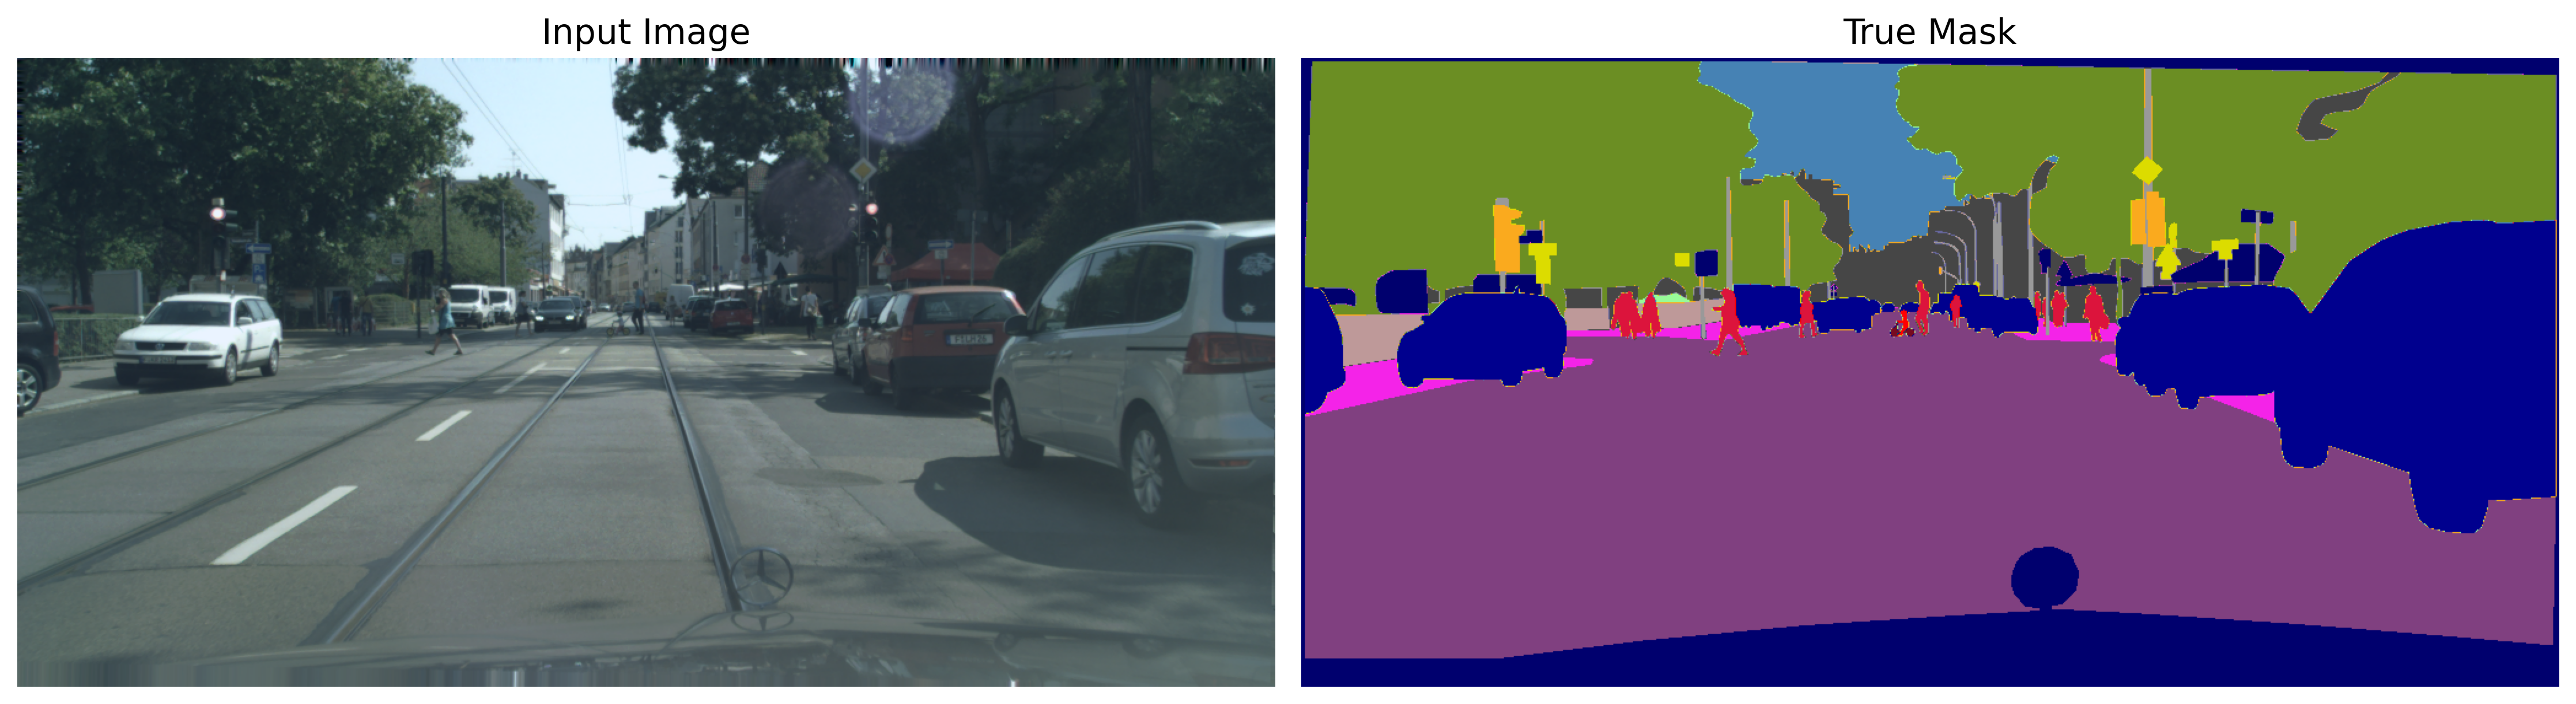

In [7]:
for image, mask in test.take(4): # 16
    sample_image, sample_mask = image, mask

if pipeline.sparse == False:
    sample_mask = tf.argmax(sample_mask, axis=-1)
sample_mask = sample_mask[..., tf.newaxis]
sample_mask = label_to_rgb(sample_mask.numpy())
display([sample_image, sample_mask])

In [8]:
model = HRNet(
    stage1_cfg = {'NUM_MODULES': 1,'NUM_BRANCHES': 1,'BLOCK': 'BOTTLENECK','NUM_BLOCKS': [4]}, 
    stage2_cfg = {'NUM_MODULES': 1,'NUM_BRANCHES': 2,'BLOCK': 'BASIC',     'NUM_BLOCKS': [4, 4]},
    stage3_cfg = {'NUM_MODULES': 4,'NUM_BRANCHES': 3,'BLOCK': 'BASIC',     'NUM_BLOCKS': [4, 4, 4]},
    stage4_cfg = {'NUM_MODULES': 3,'NUM_BRANCHES': 4,'BLOCK': 'BASIC',     'NUM_BLOCKS': [4, 4, 4, 4]},
    input_height = img_height, 
    input_width = img_width, 
    n_classes = n_classes, 
    W = 32
)

In [ ]:
model.summary()

In [ ]:
!nvidia-smi

In [9]:
if fine:
    MODEL_PATH = "weights/"+model.name+".h5"
else:
    MODEL_PATH = "weights/"+model.name+"_coarse.h5"

# model.load_weights("weights/"+model.name+"_coarse.h5")
# model.load_weights(MODEL_PATH)

In [10]:
def create_mask(pred_mask):
    pred_mask = tf.squeeze(pred_mask)
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    pred_mask = label_to_rgb(pred_mask.numpy())
    return pred_mask


def show_predictions():        
    pred_mask = model.predict(sample_image[tf.newaxis, ...])
    if "U2Net" in model.name:
        pred_mask = pred_mask[0]
    display([sample_image, sample_mask, create_mask(pred_mask)])

        
def iou_coef(y_true, y_pred):
    y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=n_classes)
    y_pred = tf.math.argmax(y_pred, axis=-1)
    y_pred = tf.one_hot(tf.cast(y_pred, tf.int32), depth=n_classes)
    smooth = 1
    iou_total = 0
    for i in range(1, n_classes):
        intersection = tf.math.reduce_sum(y_true[:,:,:,i] * y_pred[:,:,:,i], axis=(1,2))
        union = tf.math.reduce_sum(y_true[:,:,:,i] + y_pred[:,:,:,i], axis=(1,2)) 
        iou = tf.math.reduce_mean(tf.math.divide_no_nan(2.*intersection+smooth, union+smooth), axis=0)
        iou_total += iou
    return iou_total/(n_classes-1)

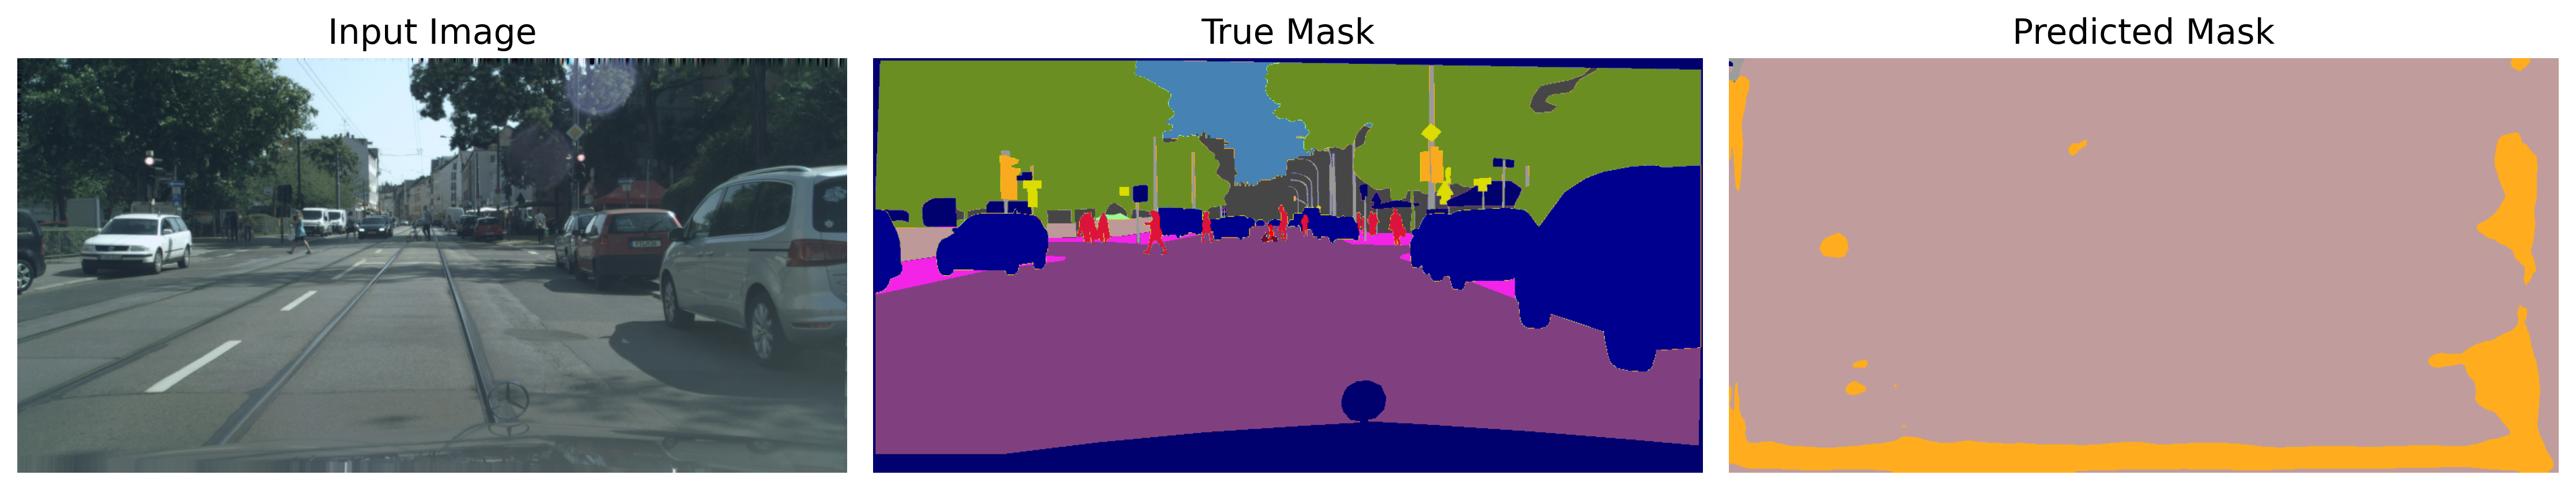

In [11]:
show_predictions()

In [12]:
EPOCHS = 200
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE 
VALIDATION_STEPS = TEST_LENGTH // BATCH_SIZE 
DECAY_STEPS = STEPS_PER_EPOCH * EPOCHS
DECAY_STEPS

148600

In [13]:
learning_rate_fn = PolynomialDecay(
    initial_learning_rate = 1e-3,
    decay_steps = DECAY_STEPS,
    end_learning_rate = 1e-6,
    power = 0.9
)

In [14]:
def weighted_cross_entropy_loss(y_true_labels, y_pred_logits):
    c_weights = [0.0,    2.602,  6.707,  3.522,  9.877, 
                 9.685,  9.398,  10.288, 9.969,  4.336, 
                 9.454,  7.617,  9.405,  10.359, 6.373, 
                 10.231, 10.262, 10.264, 10.394, 10.094] 
    
    losses = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true_labels, logits=y_pred_logits)  
    weights = tf.gather(c_weights, y_true_labels)  
    losses = tf.multiply(losses, weights)
    return tf.math.reduce_mean(losses)

In [15]:
model.compile(
    optimizer = SGD(learning_rate=learning_rate_fn, momentum=0.9, decay=0.0005),
    loss = weighted_cross_entropy_loss,
    metrics = ['accuracy', iou_coef]
)

In [16]:
callbacks = [
    EarlyStopping(monitor='val_iou_coef', mode='max', patience=30, verbose=2),
    ModelCheckpoint(MODEL_PATH, monitor='val_iou_coef', mode='max', 
                    verbose=2, save_best_only=True, save_weights_only=True)    
]

In [17]:
print(train_dataset)
print(test_dataset)

<PrefetchDataset shapes: ((None, 512, 1024, 3), (None, 512, 1024)), types: (tf.float32, tf.int32)>
<BatchDataset shapes: ((None, 512, 1024, 3), (None, 512, 1024)), types: (tf.float32, tf.int32)>


#### HRNet_W32
- 380s per epoch with BS=4, AMP, hard iou coef
- 527s per epoch with BS=4, ACCUM_STEPS=2, custom loop AMP, MeanIoU metric 

#### HRNet_GN_W32
- 931s per epoch with group size BS=2, ACCUM_STEPS=3, AMP, subclassed `model.train_step()`

In [ ]:
results = model.fit(
    train_dataset,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    epochs=EPOCHS,
    validation_data=test_dataset,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/200
743/743 [==============================] - 346s 381ms/step - loss: 6.8657 - accuracy: 0.5601 - iou_coef: 0.2758 - val_loss: 4.3652 - val_accuracy: 0.6424 - val_iou_coef: 0.3117

Epoch 00001: val_iou_coef improved from -inf to 0.31169, saving model to weights/HRNet_W32.h5
Epoch 2/200
743/743 [==============================] - 311s 415ms/step - loss: 4.3577 - accuracy: 0.7136 - iou_coef: 0.3349 - val_loss: 3.5889 - val_accuracy: 0.6957 - val_iou_coef: 0.3210

Epoch 00002: val_iou_coef improved from 0.31169 to 0.32098, saving model to weights/HRNet_W32.h5
Epoch 3/200
743/743 [==============================] - 312s 420ms/step - loss: 3.7879 - accuracy: 0.7430 - iou_coef: 0.3571 - val_loss: 3.3485 - val_accuracy: 0.7039 - val_iou_coef: 0.3335

Epoch 00003: val_iou_coef improved from 0.32098 to 0.33350, saving model to weights/HRNet_W32.h5
Epoch 4/200
743/743 [==============================] - 282s 380ms/step - loss: 3.5374 - accuracy: 0.7572 - iou_coef: 0.3579 - val_loss: 3.2666


Epoch 00031: val_iou_coef did not improve from 0.40391
Epoch 32/200
743/743 [==============================] - 280s 377ms/step - loss: 2.2640 - accuracy: 0.8237 - iou_coef: 0.4187 - val_loss: 2.3119 - val_accuracy: 0.7635 - val_iou_coef: 0.3997

Epoch 00032: val_iou_coef did not improve from 0.40391
Epoch 33/200
743/743 [==============================] - 302s 407ms/step - loss: 2.2527 - accuracy: 0.8216 - iou_coef: 0.4154 - val_loss: 2.2634 - val_accuracy: 0.7644 - val_iou_coef: 0.4017

Epoch 00033: val_iou_coef did not improve from 0.40391
Epoch 34/200
743/743 [==============================] - 281s 378ms/step - loss: 2.2756 - accuracy: 0.8231 - iou_coef: 0.4191 - val_loss: 2.3004 - val_accuracy: 0.7644 - val_iou_coef: 0.3998

Epoch 00034: val_iou_coef did not improve from 0.40391
Epoch 35/200
743/743 [==============================] - 286s 385ms/step - loss: 2.2572 - accuracy: 0.8231 - iou_coef: 0.4108 - val_loss: 2.3530 - val_accuracy: 0.7564 - val_iou_coef: 0.3913

Epoch 00035: va

In [ ]:
results = model.history

In [ ]:
def plot_history(results, model):
         
    plt.figure(figsize=(15,7))
    plt.subplot(1,3,1)  

    plt.plot(results.history['loss'], 'r', label='Training loss')
    plt.plot(results.history['val_loss'], 'b', label='Validation loss')
    plt.title("Loss: "+model.name, fontsize=16)
    plt.xlabel('Epoch', fontsize=16)
    plt.legend(prop={'size': 14})

    plt.subplot(1,3,2)
    plt.plot(results.history['accuracy'], 'r', label='Training accuracy')
    plt.plot(results.history['val_accuracy'], 'b', label='Validation accuracy')
    plt.title('Accuracy: '+model.name, fontsize=16)
    plt.xlabel('Epoch', fontsize=16)
    plt.legend(prop={'size': 14})

    plt.subplot(1,3,3)
    plt.plot(results.history['iou_coef'], 'r', label='IoU coefficient')
    plt.plot(results.history['val_iou_coef'], 'b', label='Validation IoU coefficient')
    plt.title('IoU Coefficient: '+model.name, fontsize=16)
    plt.xlabel('Epoch', fontsize=16)
    plt.legend(prop={'size': 14})
    if fine:
        plt.savefig("plots/"+model.name+"_learning_curves.png")
    else:
        plt.savefig("plots/"+model.name+"_learning_curves_coarse.png")
    plt.show()

In [ ]:
plot_history(results, model)

### Evaluation


In [ ]:
# K.clear_session()

In [ ]:
model.load_weights(MODEL_PATH)

In [ ]:
def evaluate_iou(model, dataset, n_samples):
    
    inf_times = np.zeros((n_samples, ))
    miou_op =  tf.keras.metrics.MeanIoU(num_classes=n_classes-1)
    
    for idx, (image, mask) in enumerate(dataset):
        print("\r Predicting {} \ {} ".format(idx+1, n_samples), end='')
        
        X = np.expand_dims(image.numpy(), axis=0)
        y_true = np.expand_dims(mask.numpy(), axis=0)
        
        t_start = time.time()
        y_pred = model.predict(X)
        t_end = time.time()
        t_inf = t_end-t_start
        
        inf_times[idx] = t_inf
        
        if "U2Net" in model.name:
            y_pred = y_pred[0]
            
        y_pred = tf.image.resize(y_pred, (1024, 2048))
        threshold = tf.math.reduce_max(y_pred, axis=-1, keepdims=True)
        y_pred = tf.logical_and(y_pred >= threshold, tf.abs(y_pred) > 1e-12)
        
        y_pred = tf.cast(tf.squeeze(y_pred, axis=0), tf.int32)
        y_true = tf.cast(tf.squeeze(y_true, axis=0), tf.int32)
        
        if pipeline.sparse == False:
            y_true = tf.argmax(y_true[:,:,1:], axis=-1)
        else:
            y_true = tf.one_hot(tf.cast(y_true, tf.int32), n_classes)
            y_true = tf.argmax(y_true[:,:,1:], axis=-1)
        y_pred = tf.argmax(y_pred[:,:,1:], axis=-1)
                
        miou_op.update_state(y_true, y_pred)
        
        if idx == (n_samples-1):
            break
    
    print("Average inference time: {:.2f}s".format(np.mean(inf_times)))
            
    return miou_op

In [ ]:
miou_op = evaluate_iou(model=model, dataset=eval, n_samples=TEST_LENGTH)
iou_mean = miou_op.result().numpy()

In [ ]:
union_int = np.sum(miou_op.get_weights()[0], axis=0)+np.sum(miou_op.get_weights()[0], axis=1)
inters = np.diag(miou_op.get_weights()[0])
ious = inters / (union_int-inters+1)

In [ ]:
plot_iou_trainId(
    trainId_label_map=trainid2label,
    catId_label_map=catid2label, 
    n_classes=n_classes, 
    iou_class=ious,
    model=model, 
    iou_mean=iou_mean,
)

In [ ]:
def visualize_confusion_matrix(confusion, metric, label_classes, model):
    plt.figure(figsize=(14,14))
    plt.title("{} Confusion Matrix, with Mean IoU = {:.3f}".format(model.name, metric), fontsize=22)
    plt.imshow(confusion)
    ax, fig = plt.gca(), plt.gcf()
    plt.xticks(np.arange(len(label_classes)), label_classes)
    plt.yticks(np.arange(len(label_classes)), label_classes)
    # set horizontal alignment mode (left, right or center) and rotation mode(anchor or default)
    plt.setp(ax.get_xticklabels(), rotation=-90, ha="center", rotation_mode="default")
    # avoid top and bottom part of heatmap been cut
    ax.set_xticks(np.arange(len(label_classes) + 1) - .5, minor=True)
    ax.set_yticks(np.arange(len(label_classes) + 1) - .5, minor=True)
    ax.tick_params(which="minor", bottom=False, left=False)
    ax.grid(False)
    fig.tight_layout()
    plt.show()

In [ ]:
visualize_confusion_matrix(
    confusion = miou_op.get_weights()[0] / np.sum(miou_op.get_weights()[0], axis=0), 
    metric = iou_mean, 
    label_classes = [trainid2label[i].name for i in range(1, n_classes)],
    model = model
)

In [ ]:
def show_predictions(sample_image, sample_mask):        
    pred_mask = model.predict(sample_image[tf.newaxis, ...])
    if "U2Net" in model.name:
        pred_mask = pred_mask[0]
    # sample_mask = tf.argmax(sample_mask, axis=-1)
    sample_mask = sample_mask[..., tf.newaxis]
    sample_mask = label_to_rgb(sample_mask.numpy())
    display([sample_image, sample_mask, create_mask(pred_mask)])

In [ ]:
for image, mask in test.take(96): 
    sample_image, sample_mask = image, mask
show_predictions(sample_image, sample_mask)

In [ ]:
for image, mask in test.take(4): 
    sample_image, sample_mask = image, mask
show_predictions(sample_image, sample_mask)

In [ ]:
for image, mask in test.take(27): 
    sample_image, sample_mask = image, mask
show_predictions(sample_image, sample_mask)